### RNN 

In [220]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns   
import tensorflow as tf
from tensorflow import keras
from sklearn import (
    linear_model, metrics, neural_network, pipeline, model_selection
)
from sklearn.impute import SimpleImputer

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, SimpleRNN, LSTM, TimeDistributed, BatchNormalization
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import TimeSeriesSplit
from keras.regularizers import l1, l2
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [287]:
# import the data
netflix = pd.read_csv('netflix_model_ready.csv',
                        parse_dates=True,
                        infer_datetime_format=True,
                        index_col="date"
                        )
                      


In [179]:
# Time series train/test split
tss= TimeSeriesSplit(n_splits=2)

# Keep all features, but remove the five target variables
X = netflix.iloc[:, :-5]

# Create series for target 
y = netflix.iloc[:, -3]

# Split tranining and test data by date
for train_index, test_index in tss.split(X):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [7]:
# Standardize the data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

# PCA feature reduction. 20 components is enough to explain ~85% of the variance (refer to Feture_selection notebook)
sklearn_pca = PCA(n_components=20)
X_train_pca = sklearn_pca.fit_transform(X_train)
X_test_pca = sklearn_pca.transform(X_test)

In [94]:
X_train_3D = np.reshape(X_train_pca, (X_train_pca.shape[0], 1, X_train_pca.shape[1]))
X_test_3D = np.reshape(X_test_pca, (X_test_pca.shape[0], 1, X_test_pca.shape[1]))


In [95]:
X_test_3D.shape

(240, 1, 20)

In [96]:
# Construct Long-Short Term Memory (LSTM) model
lstm = Sequential()
lstm.add(LSTM(units = 100, return_sequences = True, input_shape = (1, X_train_pca.shape[1]))) 
lstm.add(Dense(units = 1, activation="sigmoid"))

In [97]:
# Compile
lstm.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])

# Fit 
history = lstm.fit(X_train_3D, 
                y_train, 
                epochs = 10, 
                validation_data=(X_test_3D, y_test),
                batch_size = 10)

Epoch 1/10
49/49 [==============================] - 2s 11ms/step - loss: 0.6950 - accuracy: 0.4678 - val_loss: 0.6919 - val_accuracy: 0.5208
Epoch 2/10
49/49 [==============================] - 0s 4ms/step - loss: 0.6879 - accuracy: 0.5717 - val_loss: 0.6923 - val_accuracy: 0.5208
Epoch 3/10
49/49 [==============================] - 0s 3ms/step - loss: 0.6832 - accuracy: 0.5967 - val_loss: 0.6935 - val_accuracy: 0.5083
Epoch 4/10
49/49 [==============================] - 0s 3ms/step - loss: 0.6788 - accuracy: 0.5967 - val_loss: 0.6948 - val_accuracy: 0.5000
Epoch 5/10
49/49 [==============================] - 0s 3ms/step - loss: 0.6757 - accuracy: 0.5738 - val_loss: 0.6947 - val_accuracy: 0.5125
Epoch 6/10
49/49 [==============================] - 0s 3ms/step - loss: 0.6726 - accuracy: 0.5925 - val_loss: 0.6973 - val_accuracy: 0.4917
Epoch 7/10
49/49 [==============================] - 0s 3ms/step - loss: 0.6693 - accuracy: 0.5904 - val_loss: 0.6979 - val_accuracy: 0.5042
Epoch 8/10
49/49 [=

In [34]:
test_preds = lstm.predict(X_test_3D)
lstm.evaluate(X_test_3D, y_test)

8/8 [==============================] - 0s 4ms/step - loss: 0.6924 - accuracy: 0.5208


[0.6924440264701843, 0.5208333134651184]

<AxesSubplot:>

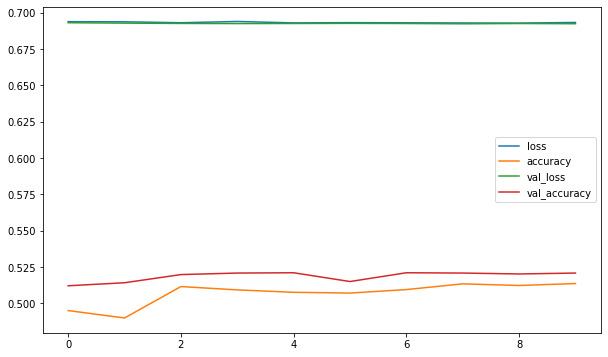

In [36]:
pd.DataFrame(history.history).plot(figsize=(10,6))

### Approach 2

In [288]:
netflix = netflix.drop(['target_1', 'target_2', 'target_4', 'target_5'], axis=1)
target_3 = netflix["target_3"]

#splitting into training sets 
column_indices = {name: i for i, name in enumerate(netflix.columns)}

n = len(netflix)
X_train = netflix[0:int(n*0.7)]
X_val = netflix[int(n*0.7):int(n*0.9)]
X_test = netflix[int(n*0.9):]

y_train = target_3[0:int(n*0.7)]
y_val = target_3[int(n*0.7):int(n*0.9)]
y_test = target_3[int(n*0.9):]

In [289]:
Mscaler = MinMaxScaler() # keeps binarys at zero and 1 :)

X_train = pd.DataFrame(Mscaler.fit_transform(X_train), columns = netflix.columns)
X_val = pd.DataFrame(Mscaler.fit_transform(X_val), columns = netflix.columns)
X_test = pd.DataFrame(Mscaler.fit_transform(X_test), columns = netflix.columns)

In [303]:
def df_to_X_y2(df, target, window_size=10):
  df_as_np = df.to_numpy() # converts to matrix of numpy arrays
  X = []
  y = []
  for i in range(len(df_as_np)-window_size): # length of data frame - window_size so it does't take empty values at the end, 
    # does force you to loose the last 5 values, could fix with padding
    row = [r for r in df_as_np[i:i+window_size]] # grabs row i and all rows above within the window size length
    X.append(row) # creates 3 dimentional array, (# obseravtions, # rows in window, # features)
    label = target[i+window_size] # pulls the target variable after the window, target varible needs to be column zero in this 
    y.append(label) # returns (N,) martix of targets i+window_length time periods away
  return np.array(X), np.array(y)

In [304]:
sklearn_pca = PCA(n_components=20)
X_train_1 = pd.DataFrame(sklearn_pca.fit_transform(X_train))
X_val_1 = pd.DataFrame(sklearn_pca.fit_transform(X_val))
X_test_1 = pd.DataFrame(sklearn_pca.fit_transform(X_test))

# converting to window format, in this case 5 periods
X_train_1, train_5w = df_to_X_y2(X_train_1,y_train)
X_val_1, val_5w = df_to_X_y2(X_val_1, y_val)
X_test_1, test_5w = df_to_X_y2(X_test_1,y_test) 

X_train1, train_5w = np.array(X_train), np.array(train_5w).reshape(-1,1)
X_val1, val_5w = np.array(X_val), np.array(val_5w).reshape(-1,1)
X_test1, test_5w = np.array(X_test), np.array(test_5w).reshape(-1,1)


print(X_train_1.shape, train_5w.shape)
print(X_val_1.shape, val_5w.shape)
print(X_test_1.shape, test_5w.shape)

(494, 10, 20) (494, 1)
(134, 10, 20) (134, 1)
(63, 10, 20) (63, 1)


In [305]:
n_steps = X_train_1.shape[1]
n_features = X_train_1.shape[2]

# Let's make a list of CONSTANTS for modelling:
LAYERS = [8, 8, 8, 1]                # number of units in hidden and output layers
M_TRAIN = X_train_1.shape[0]           # number of training examples (2D)
M_TEST = X_test_1.shape[0]             # number of test examples (2D),full=X_test.shape[0]
N = X_train_1.shape[2]                 # number of features
BATCH = M_TRAIN                          # batch size
EPOCH = 10                           # number of epochs
LR = 5e-2                            # learning rate of the gradient descent
LAMBD = 3e-2                         # lambda in L2 regularizaion
DP = 0.0                             # dropout rate
RDP = 0.0                            # recurrent dropout rate

# Build the Model
model = Sequential()
model.add(LSTM(input_shape=(n_steps, n_features), units=LAYERS[0],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
               dropout=DP, recurrent_dropout=RDP,
               return_sequences=True, return_state=False,
               stateful=False, unroll=False
              ))
model.add(BatchNormalization())
model.add(LSTM(units=LAYERS[1],
               activation='tanh', recurrent_activation='hard_sigmoid', 
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
               dropout=DP, recurrent_dropout=RDP,
               return_sequences=True, return_state=False,
               stateful=False, unroll=False
              ))
model.add(BatchNormalization())
model.add(LSTM(units=LAYERS[2],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
               dropout=DP, recurrent_dropout=RDP,
               return_sequences=False, return_state=False,
               stateful=False, unroll=False
              ))

model.add(BatchNormalization())
model.add(Dense(units=LAYERS[3], activation='sigmoid'))

In [306]:
model.compile(loss='binary_crossentropy',
              metrics=['accuracy'],
              optimizer="adam")
print(model.summary())

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_53 (LSTM)              (None, 10, 8)             928       
                                                                 
 batch_normalization_21 (Bat  (None, 10, 8)            32        
 chNormalization)                                                
                                                                 
 lstm_54 (LSTM)              (None, 10, 8)             544       
                                                                 
 batch_normalization_22 (Bat  (None, 10, 8)            32        
 chNormalization)                                                
                                                                 
 lstm_55 (LSTM)              (None, 8)                 544       
                                                                 
 batch_normalization_23 (Bat  (None, 8)              

In [307]:
lr_decay = ReduceLROnPlateau(monitor='loss', 
                             patience=1, verbose=0, 
                             factor=0.5, min_lr=1e-8)
# Define Early Stopping:
early_stop = EarlyStopping(monitor='val_acc', min_delta=0, 
                           patience=30, verbose=1, mode='auto',
                           baseline=0, restore_best_weights=True)
# Train the model. 
# The dataset is small for NN - let's use test_data for validation

history = model.fit(X_train_1, train_5w,
                    epochs=100,
                    batch_size=50,
                    validation_data=(X_val_1, val_5w))

Epoch 1/100
10/10 [==============================] - 6s 73ms/step - loss: 2.9503 - accuracy: 0.4777 - val_loss: 2.7538 - val_accuracy: 0.5597
Epoch 2/100
10/10 [==============================] - 0s 23ms/step - loss: 2.7688 - accuracy: 0.4818 - val_loss: 2.6267 - val_accuracy: 0.5224
Epoch 3/100
10/10 [==============================] - 0s 20ms/step - loss: 2.5983 - accuracy: 0.5162 - val_loss: 2.5038 - val_accuracy: 0.5000
Epoch 4/100
10/10 [==============================] - 0s 18ms/step - loss: 2.4660 - accuracy: 0.5202 - val_loss: 2.3863 - val_accuracy: 0.4925
Epoch 5/100
10/10 [==============================] - 0s 20ms/step - loss: 2.3349 - accuracy: 0.5445 - val_loss: 2.2760 - val_accuracy: 0.4478
Epoch 6/100
10/10 [==============================] - 0s 19ms/step - loss: 2.2243 - accuracy: 0.5445 - val_loss: 2.1715 - val_accuracy: 0.4478
Epoch 7/100
10/10 [==============================] - 0s 20ms/step - loss: 2.1161 - accuracy: 0.5567 - val_loss: 2.0728 - val_accuracy: 0.4552
Epoch 

In [308]:
# Evaluate the model:
train_loss, train_acc = model.evaluate(X_train_1, train_5w,
                                       batch_size=M_TRAIN, verbose=0)
test_loss, test_acc = model.evaluate(X_test_1, test_5w,
                                     batch_size=M_TEST, verbose=0)
print('-'*65)
print(f'train accuracy = {round(train_acc * 100, 4)}%')
print(f'test accuracy = {round(test_acc * 100, 4)}%')
print(f'test error = {round((1 - test_acc) * M_TEST)} out of {M_TEST} examples')

-----------------------------------------------------------------
train accuracy = 77.1255%
test accuracy = 53.9683%
test error = 29 out of 63 examples


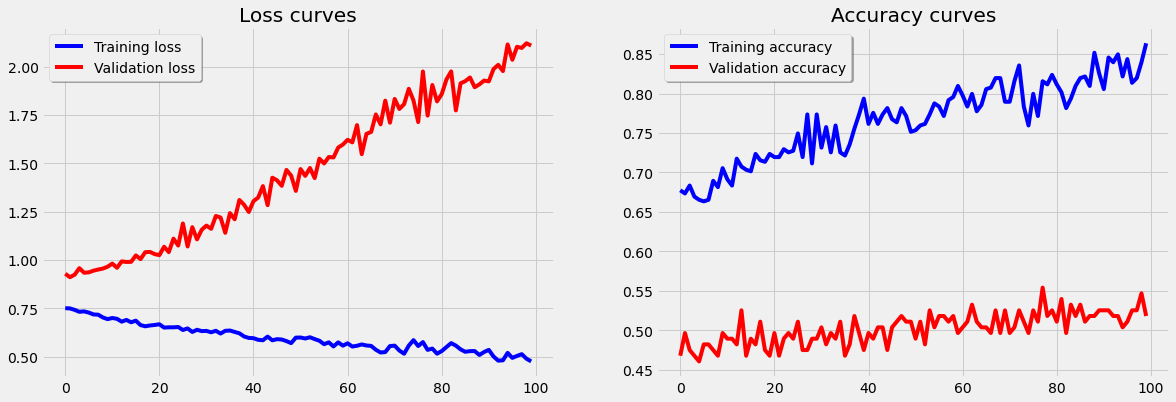

In [302]:
# Plot the loss and accuracy curves over epochs:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
axs[0].plot(history.history['loss'], color='b', label='Training loss')
axs[0].plot(history.history['val_loss'], color='r', label='Validation loss')
axs[0].set_title("Loss curves")
axs[0].legend(loc='best', shadow=True)
axs[1].plot(history.history['accuracy'], color='b', label='Training accuracy')
axs[1].plot(history.history['val_accuracy'], color='r', label='Validation accuracy')
axs[1].set_title("Accuracy curves")
axs[1].legend(loc='best', shadow=True)
plt.show()

In [310]:
y_hat = model.predict(X_test_1, batch_size=50, verbose=1)
#score = sum(y_hat == y_test) / len(y_test)
#print(f'Prediction accuracy = {score*100}%')
index = pd.date_range(start='2017-01-02', end='2018-06-19', freq='B')
for i in range(y_hat.shape[0]):
    print(index[i], y_hat[i], test_5w[i])

2/2 [==============================] - 0s 3ms/step
2017-01-02 00:00:00 [0.17891988] [1]
2017-01-03 00:00:00 [0.05630448] [0]
2017-01-04 00:00:00 [0.03580853] [0]
2017-01-05 00:00:00 [0.02146208] [0]
2017-01-06 00:00:00 [0.06438792] [0]
2017-01-09 00:00:00 [0.26083684] [0]
2017-01-10 00:00:00 [0.64178264] [0]
2017-01-11 00:00:00 [0.87485814] [1]
2017-01-12 00:00:00 [0.693587] [0]
2017-01-13 00:00:00 [0.62436056] [0]
2017-01-16 00:00:00 [0.6126578] [1]
2017-01-17 00:00:00 [0.31980342] [0]
2017-01-18 00:00:00 [0.19437158] [1]
2017-01-19 00:00:00 [0.15343577] [0]
2017-01-20 00:00:00 [0.39009175] [0]
2017-01-23 00:00:00 [0.36873668] [0]
2017-01-24 00:00:00 [0.54127914] [0]
2017-01-25 00:00:00 [0.42972645] [0]
2017-01-26 00:00:00 [0.09717023] [1]
2017-01-27 00:00:00 [0.01202509] [0]
2017-01-30 00:00:00 [0.00709307] [1]
2017-01-31 00:00:00 [0.0088695] [1]
2017-02-01 00:00:00 [0.02089989] [0]
2017-02-02 00:00:00 [0.05778971] [0]
2017-02-03 00:00:00 [0.1075733] [1]
2017-02-06 00:00:00 [0.280485

[Text(0, 0.5, 'True: 0'), Text(0, 1.5, 'True: 1')]

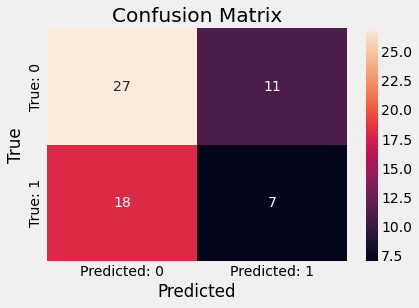

In [311]:
# Display confusion matrix results
from sklearn.metrics import confusion_matrix

ax = plt.subplot()
predicted = model.predict(X_test_1)
predicted = (predicted > 0.5)

confusion = confusion_matrix(test_5w, predicted)

sns.heatmap(confusion, annot=True, ax=ax)

ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(["Predicted: 0", "Predicted: 1"])
ax.yaxis.set_ticklabels(["True: 0", "True: 1"])